In [146]:
#Goal:
# Create a model to accurately predict Employee Attrition
# Identify key factors related to employee churn

#Parameters:
# - 2018- YTD 2020 Terminations
# - Active Employees as of end of most recent month
# - Excludes Contractor/Consultant and Intern Employee Type

# Next Steps/ToDo:
# - Try to run model excluding CCAT but keeping 2018 Terminations
# - Try to run model with Months instead of Years for Tenure
# - Research PCA
# - Research get_dummies
# - Hyper parameter tuning
# - Estimators range = 0-10
# - Talk to Talent Team on importances

# Resources:
# https://www.kaggle.com/hamzaben/employee-churn-model-w-strategic-retention-plan
# https://medium.com/analytics-vidhya/predict-employee-attrition-a34e2c5a972d
# https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

In [147]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn modules for ML model selection
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Libraries for data modelling
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Common sklearn Model Helpers
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
# from sklearn.datasets import make_classification

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score

# Import Chi-Squared Testing
import scipy.stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency

# Import SMOTE and Metrics Libraries
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import (accuracy_score, log_loss, classification_report)

## Premodeling/Clean-Up

In [148]:
#Load Data
df = pd.read_csv(r'C:\Users\rklaud\OneDrive - Icims, Inc\Talent Metrics Dashboard\01_Talent Mangement\AttritionModel\Cumulative Headcount_AttritionModel.csv')
df['Voluntary/Involuntary Termination Flag']=df['Voluntary/Involuntary Termination Flag'].fillna('Active')
df=df[df['Voluntary/Involuntary Termination Flag']!='Involuntary'] #<-- Filter out Involuntary Terminations which might be skewing analysis
df=df[df['Year of As Of']>2018]
df=df.drop('Year of As Of', axis=1)

In [149]:
df.tail(7)

,EmployeeNumber,Position Status,Manager Change Prior Year for Model?,Voluntary/Involuntary Termination Flag,Termination Reason Description,Parent Entity,Accounting Group,Supervisor EmployeeNumber,Experience Level (Numeric),Level 1 - Role Class,...,On Target Earnings (OTE) Percentile,Age Bucket (Years),Age (Years),CCAT Score,CCAT Score (Group),Termination Month,Salary % Change Prior Year for Model,Most Recent Review (Text) (group),Most Recent Supervisor Review (Text) (group),Training Hours
1259,994622622,Active,True,Active,NaN,Services,Services,2814204.0,1,Staff,...,26.38%,25-34,26,34.0,4.0,0,1.00%,3,4,94.7
1260,994628628,Terminated,False,Voluntary,Other Job,G&A,Finance,2517417.0,2,Staff,...,28.54%,25-34,27,35.0,4.0,7,3.57%,4,3,68.0
1261,994720720,Active,True,Active,NaN,G&A,Finance,84929899.0,2,Staff,...,75.77%,25-34,33,32.0,4.0,0,0.00%,4,4,174.7
1262,994825875,Active,True,Active,NaN,Services,Services,2814204.0,1,Staff,...,26.38%,25-34,27,33.0,4.0,0,1.00%,3,4,83.7
1264,994827807,Active,True,Active,NaN,Services,Services,2313513.0,1,Staff,...,26.38%,25-34,28,36.0,5.0,0,1.00%,3,3,81.2
1265,994827847,Active,True,Active,NaN,Sales,Sales,2113913.0,1,Staff,...,47.04%,25-34,28,33.0,4.0,0,0.00%,0,3,148.5
1267,994925905,Active,True,Active,NaN,Services,Services,2514914.0,1,Staff,...,82.57%,25-34,29,38.0,5.0,0,228.75%,3,3,94.2


In [150]:
print(df.shape)
print(df.dtypes)

(991, 39)
EmployeeNumber                                    int64
Position Status                                  object
Manager Change Prior Year for Model?               bool
Voluntary/Involuntary Termination Flag           object
Termination Reason Description                   object
Parent Entity                                    object
Accounting Group                                 object
Supervisor EmployeeNumber                       float64
Experience Level (Numeric)                        int64
Level 1 - Role Class                             object
Level 2 - Role Type                              object
Level 3 - Role Type Detail                       object
Location Description (group)                     object
Legal / Preferred Address: Country               object
Pay Grade Code (group)                           object
Position Status Terminated                         bool
Employee Type                                    object
Gender                                

False    787
True     204
Name: Position Status Terminated, dtype: int64


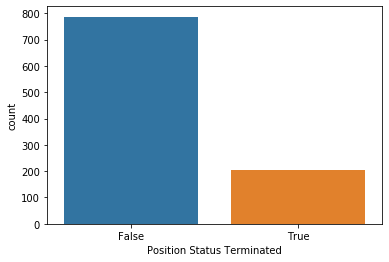

In [151]:
#Table and graph
print(df['Position Status Terminated'].value_counts())
sns.countplot(df['Position Status Terminated'])

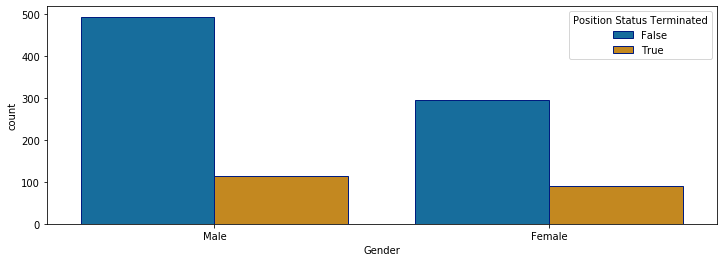

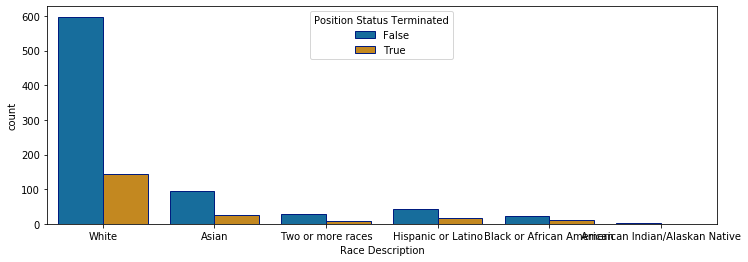

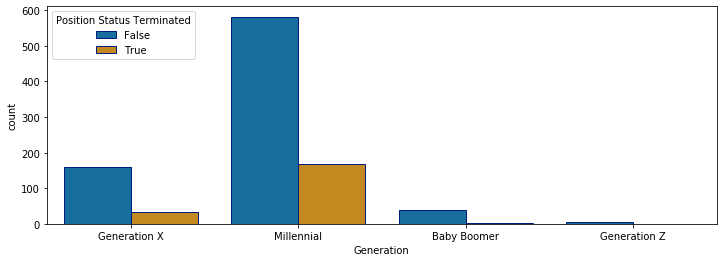

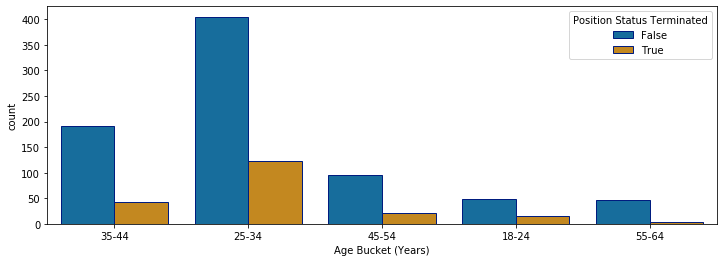

In [152]:
#Show the number of employees that left and stayed by Gender
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
    #ax = axis
sns.countplot(x='Gender', hue='Position Status Terminated', data = df, palette="colorblind", ax = ax,  edgecolor=sns.color_palette("dark", n_colors = 1));

#Show the number of employees that left and stayed by Race
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
    #ax = axis
sns.countplot(x='Race Description', hue='Position Status Terminated', data = df, palette="colorblind", ax = ax,  edgecolor=sns.color_palette("dark", n_colors = 1));

#Show the number of employees that left and stayed by Generation
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
    #ax = axis
sns.countplot(x='Generation', hue='Position Status Terminated', data = df, palette="colorblind", ax = ax,  edgecolor=sns.color_palette("dark", n_colors = 1));

#Show the number of employees that left and stayed by age
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
    #ax = axis
sns.countplot(x='Age Bucket (Years)', hue='Position Status Terminated', data = df, palette="colorblind", ax = ax,  edgecolor=sns.color_palette("dark", n_colors = 1));


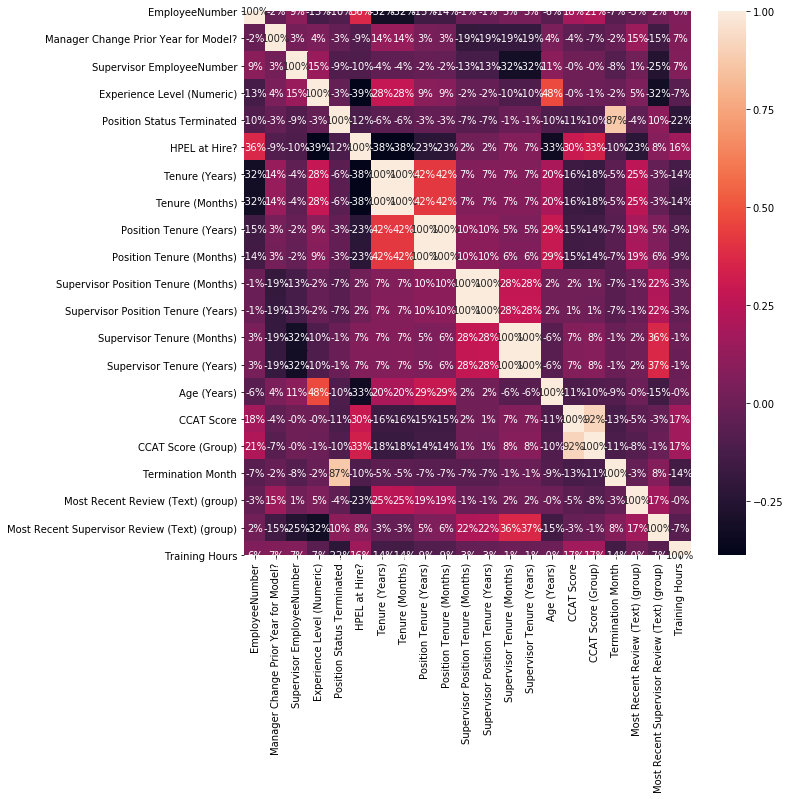

In [153]:
#Visualize the correlations table
plt.figure(figsize=(10,10)) #14in x 14in
sns.heatmap(df.corr(), annot=True, fmt='.0%')
# df.corr()

In [154]:
df.isnull().sum()

EmployeeNumber                                    0
Position Status                                   0
Manager Change Prior Year for Model?              0
Voluntary/Involuntary Termination Flag            0
Termination Reason Description                  787
Parent Entity                                     0
Accounting Group                                  0
Supervisor EmployeeNumber                         2
Experience Level (Numeric)                        0
Level 1 - Role Class                              0
Level 2 - Role Type                               0
Level 3 - Role Type Detail                        0
Location Description (group)                      0
Legal / Preferred Address: Country                0
Pay Grade Code (group)                            0
Position Status Terminated                        0
Employee Type                                     0
Gender                                            0
Generation                                        0
Race Descrip

In [155]:
# Convert NULL Values to 0, moved before Chi2
# df['Termination Month']=df['Termination Month'].fillna(0)
df['Position Tenure (Years)']=df['Position Tenure (Years)'].fillna(0)
df['Supervisor Position Tenure (Years)']=df['Supervisor Position Tenure (Years)'].fillna(0)
df['Supervisor Tenure (Years)']=df['Supervisor Tenure (Years)'].fillna(0)
df['CCAT Score (Group)']=df['CCAT Score (Group)'].fillna(0)
df['CCAT Score']=df['CCAT Score'].fillna(0)
df['Training Hours']=df['Training Hours'].fillna(0)

# df['Position Tenure (Months)']=df['Position Tenure (Months)'].fillna(0)
# df['Supervisor Position Tenure (Months)']=df['Supervisor Position Tenure (Months)'].fillna(0)
# df['Supervisor Tenure (Months)']=df['Supervisor Tenure (Months)'].fillna(0)
# df=df.fillna(0)

In [156]:
df.isnull().sum()

EmployeeNumber                                    0
Position Status                                   0
Manager Change Prior Year for Model?              0
Voluntary/Involuntary Termination Flag            0
Termination Reason Description                  787
Parent Entity                                     0
Accounting Group                                  0
Supervisor EmployeeNumber                         2
Experience Level (Numeric)                        0
Level 1 - Role Class                              0
Level 2 - Role Type                               0
Level 3 - Role Type Detail                        0
Location Description (group)                      0
Legal / Preferred Address: Country                0
Pay Grade Code (group)                            0
Position Status Terminated                        0
Employee Type                                     0
Gender                                            0
Generation                                        0
Race Descrip

In [157]:
# Drop Fields before Feature Engineering
df=df.drop('EmployeeNumber', axis=1)
df=df.drop('Supervisor EmployeeNumber', axis=1)
df=df.drop('Termination Reason Description', axis=1)
df=df.drop('Pay Grade Code (group)',axis=1)
df=df.drop('Position Status', axis=1)
df=df.drop('Employee Type',axis=1)
df=df.drop('Voluntary/Involuntary Termination Flag', axis=1)
df=df.drop('Level 1 - Role Class',axis=1)
df=df.drop('Level 2 - Role Type',axis=1)

# Dropped 'Months' fields due to increased range variability compared to 'Years'
df=df.drop('Tenure (Months)', axis=1)
df=df.drop('Position Tenure (Months)', axis=1)
df=df.drop('Supervisor Tenure (Months)', axis=1)
df=df.drop('Supervisor Position Tenure (Months)', axis=1)

# Drop CCAT since we are including 2018 Terminations
# df=df.drop('CCAT Score (Group)', axis=1)
# df=df.drop('CCAT Score', axis=1)

# After further analysis, we decided to drop duplicative fields that originally were intended to become categorical XXX Include in v1
df=df.drop('Age Bucket (Years)', axis=1)
df=df.drop('Experience Level (Numeric)', axis=1)

# Drop Training Hours to see original output
# df=df.drop('Training Hours', axis=1)

## Feature Engineering
    xxxv Based on below, we determined the features to drop from the model
   

In [158]:
# Chi-Squared Test
df3=df.select_dtypes(include='object')

df4=pd.DataFrame(columns=df3.columns,index=['no_of_rows','no_of_columns','DOF','alpha','chi_square_statistic','critical_value','p_value'])
for col in df3.columns:
        observed=[]
        expected=[]
        chi_square=[]
        df4[col][0]=((pd.crosstab(df[col],df['Position Status Terminated'])).shape[0])
        df4[col][1]=((pd.crosstab(df[col],df['Position Status Terminated'])).shape[1])
        df4[col][2]=(df4[col][0]-1)*(df4[col][1]-1)
        df4[col][3]=0.05
        observed=(pd.crosstab(df[col],df['Position Status Terminated']).values)
        expected=(scipy.stats.chi2_contingency(pd.crosstab(df[col],df['Position Status Terminated']))[3])
        chi_square=(sum([(o-e)**2./e for o,e in zip(observed,expected)]))
        df4[col][4]=chi_square[0]+chi_square[1]
        df4[col][5]=chi2.ppf(q=1-0.05,df=df4[col][2])
        df4[col][6]=1-chi2.cdf(x=df4[col][4],df=df4[col][2])
        del chi_square
        del expected
        del observed

In [159]:
df4

,Parent Entity,Accounting Group,Level 3 - Role Type Detail,Location Description (group),Legal / Preferred Address: Country,Gender,Generation,Race Description,On Target Earnings (OTE) Percentile,Salary % Change Prior Year for Model
no_of_rows,5,13,16,8,3,2,4,6,774,413
no_of_columns,2,2,2,2,2,2,2,2,2,2
DOF,4,12,15,7,2,1,3,5,773,412
alpha,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
chi_square_statistic,31.9611,40.2273,32.9919,32.4396,5.0213,3.11981,8.61954,5.72348,843.96,422.672
critical_value,9.48773,21.0261,24.9958,14.0671,5.99146,3.84146,7.81473,11.0705,838.791,460.326
p_value,1.94842e-06,6.59199e-05,0.00470594,3.36598e-05,0.0812153,0.0773457,0.0348013,0.334062,0.0384382,0.347601


In [160]:
#Drop Columns if# Stat<critical value, pvalue>0.05 (Chi2test)
for i in range(0,len(df4.columns)):
    if ((df4.iloc[4,:].values[i] < df4.iloc[5,:].values[i]) and df4.iloc[6,:].values[i] > 0.05):
        df=df.drop(df4.columns[i],axis=1)
# print('#Features dropped from Chi2')
print(df4.columns[i])

Salary % Change Prior Year for Model


In [161]:
# Drop Multicollinearity fields from analysis
df=df.drop('Termination Month', axis=1)

#Create Data Frames for Features
# gender_df=pd.DataFrame(df,columns=['Gender'])
# generation_df=pd.DataFrame(df,columns=['Generation'])
# termflag_df=pd.DataFrame(df,columns=['Voluntary/Involuntary Termination Flag'])
# race_df=pd.DataFrame(df,columns=['Race Description'])

#Transform with OneHotLoad to generate binary values using get_dummies
# dum_gender_df=pd.get_dummies(gender_df, columns=["Gender"], prefix=["Gender_is"])
# dum_generation_df=pd.get_dummies(generation_df, columns=["Generation"], prefix=["Generation_is"])
# dum_termflag_df=pd.get_dummies(termflag_df, columns=["Voluntary/Involuntary Termination Flag"], prefix=["Termination_is"])
# dum_race_df = pd.get_dummies(race_df, columns=["Race Description"], prefix=["Race_is"] )

#Merge with main df
# df=df.join(dum_gender_df)
# df=df.join(dum_generation_df)
# df=df.join(dum_termflag_df)
# df=df.join(dum_race_df)
# pd.get_dummies(df)
# df

# Drop Fields used for get_dummies
# df=df.drop('Gender',axis=1)
# df=df.drop('Generation',axis=1)
# df=df.drop('Voluntary/Involuntary Termination Flag',axis=1)
# df=df.drop('Race Description',axis=1)

In [162]:
df

,Manager Change Prior Year for Model?,Parent Entity,Accounting Group,Level 3 - Role Type Detail,Location Description (group),Position Status Terminated,Generation,HPEL at Hire?,Tenure (Years),Position Tenure (Years),Supervisor Position Tenure (Years),Supervisor Tenure (Years),On Target Earnings (OTE) Percentile,Age (Years),CCAT Score,CCAT Score (Group),Most Recent Review (Text) (group),Most Recent Supervisor Review (Text) (group),Training Hours
103,True,Services,Services,Staff - II,NJ HQ,True,Generation X,0,3.7,0.8,0.8,4.5,20.85%,40,30.0,3.0,3,4,28.0
104,True,Services,Services,Manager - Associate,Remote,True,Millennial,0,5.4,0.5,1.0,13.7,26.27%,32,33.0,4.0,3,3,0.0
105,True,iCIMS Labs,R&D,Staff - III,NJ HQ,True,Millennial,0,5.7,0.4,0.4,0.8,17.21%,33,25.0,1.0,3,3,17.7
106,True,iCIMS Labs,R&D,Staff - V,NJ HQ,True,Generation X,0,15.6,4.3,0.1,14.0,88.76%,39,36.0,5.0,3,3,0.0
108,True,Sales,Sales,Staff - III,NJ HQ,True,Generation X,0,3.9,3.9,0.8,0.8,53.05%,50,20.0,1.0,2,2,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,True,G&A,Finance,Staff - II,NJ HQ,False,Millennial,0,1.0,0.2,0.2,1.4,75.77%,33,32.0,4.0,4,4,174.7
1262,True,Services,Services,Staff - I,NJ HQ,False,Millennial,1,1.1,1.1,1.3,4.4,26.38%,27,33.0,4.0,3,4,83.7
1264,True,Services,Services,Staff - I,NJ HQ,False,Millennial,1,1.1,1.1,0.7,6.4,26.38%,28,36.0,5.0,3,3,81.2
1265,True,Sales,Sales,Staff - I,NJ HQ,False,Millennial,1,0.2,0.2,0.1,6.4,47.04%,28,33.0,4.0,0,3,148.5


In [163]:
# Original Transform non-numeric columns into numerical values to proceed with multi collinearity

from sklearn.preprocessing import LabelEncoder

for column in df.columns:
        if (df[column].dtype == object or df[column].dtype == bool) :
            df[column] = LabelEncoder().fit_transform(df[column])
        else:
            pass

In [164]:
df.dtypes

Manager Change Prior Year for Model?              int64
Parent Entity                                     int32
Accounting Group                                  int32
Level 3 - Role Type Detail                        int32
Location Description (group)                      int32
Position Status Terminated                        int64
Generation                                        int32
HPEL at Hire?                                     int64
Tenure (Years)                                  float64
Position Tenure (Years)                         float64
Supervisor Position Tenure (Years)              float64
Supervisor Tenure (Years)                       float64
On Target Earnings (OTE) Percentile               int32
Age (Years)                                       int64
CCAT Score                                      float64
CCAT Score (Group)                              float64
Most Recent Review (Text) (group)                 int64
Most Recent Supervisor Review (Text) (group)    

## Multicollinearity
    If correlations are >80% then removing from analysis, because it may inflate variance in model

In [165]:
# Check for multicollnearity and remove columns if VIF is > 5
  
# the independent variables set 
X = df.drop('Position Status Terminated', axis=1)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
  
for i in range(0,vif_data.shape[0]):
    if vif_data["VIF"][i]>5:
#         df=df.drop(vif_data["feature"][i],axis=1)
           print(vif_data["feature"][i]) 
    
vif_data

Parent Entity
Accounting Group
Level 3 - Role Type Detail
Location Description (group)
Generation
Age (Years)
CCAT Score
CCAT Score (Group)
Most Recent Review (Text) (group)
Most Recent Supervisor Review (Text) (group)


,feature,VIF
0,Manager Change Prior Year for Model?,2.696299
1,Parent Entity,5.326610
2,Accounting Group,15.885198
3,Level 3 - Role Type Detail,13.388544
4,Location Description (group),10.655580
5,Generation,15.954945
6,HPEL at Hire?,1.774680
7,Tenure (Years),3.403966
8,Position Tenure (Years),3.060276
9,Supervisor Position Tenure (Years),2.691481


## Train and Test Algorithms to determine best fit

In [166]:
#  Declare Train and Test
x_train, x_test, y_train, y_test = train_test_split(df.drop('Position Status Terminated',axis=1),
                                                    df['Position Status Terminated'],
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=df['Position Status Terminated'] ) 

In [167]:
# Selection of algorithms to consider and set performance measure
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state=7,
                                                         class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100, random_state=7)))
models.append(('SVM', SVC(gamma='auto', random_state=7)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(random_state=7)))
models.append(('Gaussian NB', GaussianNB()))

In [168]:
# Evaluate each model's accuracy and standard deviation scores
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, random_state=7)  # 10-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(  # accuracy scoring
        model, x_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(  # roc_auc scoring
        model, x_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

C:\Users\rklaud\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\rklaud\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\rklaud\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\rklaud\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\mod

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
1,Random Forest,85.60,3.03,86.68,2.97
0,Logistic Regression,71.66,4.95,67.01,4.90
4,Decision Tree Classifier,68.51,5.88,81.16,3.40
3,KNN,66.67,5.91,81.01,3.91
5,Gaussian NB,66.38,5.37,75.90,4.92
2,SVM,62.47,7.31,79.40,4.84


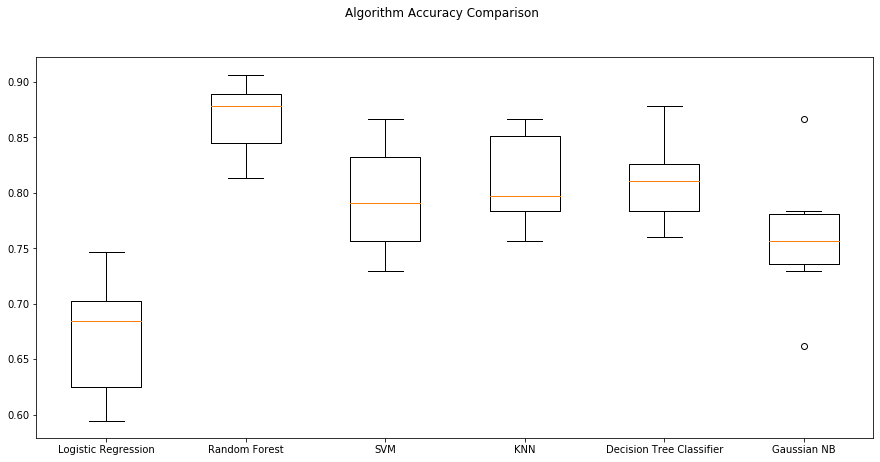

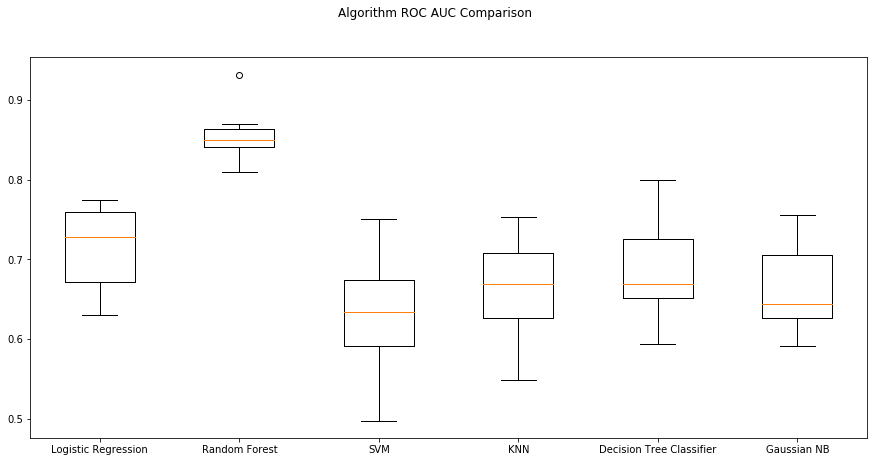

Box Plots show that Random Forest is the best model to move forward with


In [169]:
# Box plot of model Accuracy
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

# ROC AUC Comparison
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm ROC AUC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.show()

print('Box Plots show that Random Forest is the best model to move forward with')

In [170]:
# Original Model
#Split data into independent 'X' and depedent 'Y' Variables
X = df.drop('Position Status Terminated', axis=1) # Exclude Target Variable
Y = df['Position Status Terminated'] # Set Target Variable to whether or not the Employee was Terminated

#validation split

train_ratio = 0.65
validation_ratio = 0.20
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio)


X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

# print(x_train, x_val, x_test)


#Split data into 75% Training and 25% Testing data sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=0)



# SMOTE Technique to determine oversampling
# oversampler=SMOTE(random_state=0)
# X_train, Y_train = oversampler.fit_sample(X_train,Y_train)

# SMOTENC Technique to determine oversampling
smotenc = SMOTENC([1],random_state = 101)
X_train, Y_train = smotenc.fit_resample(X_train, Y_train)

#Use Random Forest Classification algo
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 21, criterion = 'entropy', random_state = 0)
forest.fit(X_train, Y_train)
# Checked nestimators 20-25 and determined 21 was optimal

#Get the accuracy on the training data
print('Forest Score = "{}!"'.format(forest.score(X_train, Y_train)))

#Show the confusion matrix and accuracy for  the model on the test data
#Classification accuracy is the ratio of correct predictions to total predictions made.
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, forest.predict(X_test))
  
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

print(pd.crosstab(Y_test, forest.predict(X_test), rownames = ['Actual'], colnames =['Predicted'], margins = True))
# print(cm)
print()# Print a new line
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print("Accuracy score: {}".format(accuracy_score(Y_test, forest.predict(X_test))))
print("="*80)
print(classification_report(Y_test, forest.predict(X_test)))
print('XXX^ Forest Score being greater than 7% variance from Accuracy indicates overfitting')



#Show the confusion matrix and accuracy for  the model on the validation data
#Classification accuracy is the ratio of correct predictions to total predictions made.
print("")
print("Validation result")
print("")
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_val, forest.predict(X_val))
  
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

print(pd.crosstab(Y_val, forest.predict(X_val), rownames = ['Actual'], colnames =['Predicted'], margins = True))
# print(cm)
print()# Print a new line
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print("Accuracy score: {}".format(accuracy_score(Y_val, forest.predict(X_val))))
print("="*80)
print(classification_report(Y_val, forest.predict(X_val)))
print('XXX^ Forest Score being greater than 7% variance from Accuracy indicates overfitting')

Forest Score = "1.0!"
Predicted    0   1  All
Actual                 
0          109   5  114
1           19  16   35
All        128  21  149

Model Testing Accuracy = "0.8389261744966443!"
Accuracy score: 0.8389261744966443
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       114
           1       0.76      0.46      0.57        35

    accuracy                           0.84       149
   macro avg       0.81      0.71      0.74       149
weighted avg       0.83      0.84      0.82       149

XXX^ Forest Score being greater than 7% variance from Accuracy indicates overfitting

Validation result

Predicted    0   1  All
Actual                 
0          148  11  159
1           12  27   39
All        160  38  198

Model Testing Accuracy = "0.8838383838383839!"
Accuracy score: 0.8838383838383839
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       159
           1       0.71      0.

In [171]:
for dataset in [Y_train, Y_val, Y_test]:
    print(len(dataset)/len(Y))

1.0373360242179617
0.19979818365287588
0.1503531786074672


In [172]:
# Hyper parameterization, Model Run 1

# #Split data into independent 'X' and depedent 'Y' Variables
# X = df.drop('Position Status Terminated', axis=1) # Exclude Target Variable
# Y = df['Position Status Terminated'] # Set Target Variable to whether or not the Employee was Terminated

# #Split data into 75% Training and 25% Testing data sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=0)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 50, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
max_depth = [1,7]

# # Minimum number of samples required to split a node
min_samples_split = [100, 120]

# # Minimum number of samples required at each leaf node
min_samples_leaf = [100, 120]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

print(param_grid)

rf_Model = RandomForestClassifier()

rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4)

rf_Grid.fit(X_train, Y_train)

print(rf_Grid.best_params_)
print (f'Train Accuracy - : {rf_Grid.score(X_train,Y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,Y_test):.3f}')

{'n_estimators': [0, 5, 11, 16, 22, 27, 33, 38, 44, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 7], 'min_samples_split': [100, 120], 'min_samples_leaf': [100, 120], 'bootstrap': [True, False]}
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 423 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 1235 tasks      | elapsed:   24.9s


{'bootstrap': False, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 100, 'min_samples_split': 100, 'n_estimators': 27}
Train Accuracy - : 0.816
Test Accuracy - : 0.758


[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:   33.2s finished


In [173]:
# Hyper parameters Model Run 1 Output

# SMOTE Technique to determine oversampling
# oversampler=SMOTE(random_state=0)
# X_train, Y_train = oversampler.fit_sample(X_train,Y_train)

# SMOTENC Technique to determine oversampling
smotenc = SMOTENC([1],random_state = 0)
X_train, Y_train = smotenc.fit_resample(X_train, Y_train)

#Use Random Forest Classification algo
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(bootstrap=rf_Grid.best_params_['bootstrap'],
max_depth=rf_Grid.best_params_['max_depth'],
max_features= rf_Grid.best_params_['max_features'],
min_samples_leaf= rf_Grid.best_params_['min_samples_leaf'],
min_samples_split= rf_Grid.best_params_['min_samples_split'],
n_estimators= rf_Grid.best_params_['n_estimators'],
random_state = 0)
forest.fit(X_train, Y_train)

#Get the accuracy on the training data
print('Forest Score = "{}!"'.format(forest.score(X_train, Y_train)))

#Show the confusion matrix and accuracy for  the model on the test data
#Classification accuracy is the ratio of correct predictions to total predictions made.
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, forest.predict(X_test))
  
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

print(pd.crosstab(Y_test, forest.predict(X_test), rownames = ['Actual'], colnames =['Predicted'], margins = True))
# print(cm)
print()# Print a new line
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print("Accuracy score: {}".format(accuracy_score(Y_test, forest.predict(X_test))))
print("="*80)
print(classification_report(Y_test, forest.predict(X_test)))
print('XXX^ Forest Score being greater than 7% variance from Accuracy indicates overfitting')



#Show the confusion matrix and accuracy for  the model on the validation data
#Classification accuracy is the ratio of correct predictions to total predictions made.
print("")
print("Validation result")
print("")
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_val, forest.predict(X_val))
  
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

print(pd.crosstab(Y_val, forest.predict(X_val), rownames = ['Actual'], colnames =['Predicted'], margins = True))
# print(cm)
print()# Print a new line
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print("Accuracy score: {}".format(accuracy_score(Y_val, forest.predict(X_val))))
print("="*80)
print(classification_report(Y_val, forest.predict(X_val)))
print('XXX^ Forest Score being greater than 7% variance from Accuracy indicates overfitting')

Forest Score = "0.8317120622568094!"
Predicted    0   1  All
Actual                 
0           96  18  114
1           17  18   35
All        113  36  149

Model Testing Accuracy = "0.7651006711409396!"
Accuracy score: 0.7651006711409396
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       114
           1       0.50      0.51      0.51        35

    accuracy                           0.77       149
   macro avg       0.67      0.68      0.68       149
weighted avg       0.77      0.77      0.77       149

XXX^ Forest Score being greater than 7% variance from Accuracy indicates overfitting

Validation result

Predicted    0   1  All
Actual                 
0          137  22  159
1           12  27   39
All        149  49  198

Model Testing Accuracy = "0.8282828282828283!"
Accuracy score: 0.8282828282828283
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       159
           1    

In [174]:
# Return the feature importances (the higher, the more important the feature).
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(forest.feature_importances_,3)}) #Note: The target column is at position 0
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
Training Hours,0.339
Level 3 - Role Type Detail,0.133
Supervisor Position Tenure (Years),0.078
Parent Entity,0.060
CCAT Score (Group),0.058
Tenure (Years),0.052
Accounting Group,0.050
HPEL at Hire?,0.049
Manager Change Prior Year for Model?,0.046


In [175]:
# Hyper parameterization, Model Run 2

# #Split data into independent 'X' and depedent 'Y' Variables
# X = df.drop('Position Status Terminated', axis=1) # Exclude Target Variable
# Y = df['Position Status Terminated'] # Set Target Variable to whether or not the Employee was Terminated

# #Split data into 75% Training and 25% Testing data sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=0)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
max_depth = [1,7]

# # Minimum number of samples required to split a node
min_samples_split = [100, 200]

# # Minimum number of samples required at each leaf node
min_samples_leaf = [100, 200]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

print(param_grid)

rf_Model = RandomForestClassifier()

rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4)

rf_Grid.fit(X_train, Y_train)

print(rf_Grid.best_params_)
print (f'Train Accuracy - : {rf_Grid.score(X_train,Y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,Y_test):.3f}')

{'n_estimators': [50, 55, 61, 66, 72, 77, 83, 88, 94, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 7], 'min_samples_split': [100, 200], 'min_samples_leaf': [100, 200], 'bootstrap': [True, False]}
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   16.9s
[Parallel(n_jobs=4)]: Done 706 tasks      | elapsed:   39.3s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:  1.5min finished


{'bootstrap': False, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}
Train Accuracy - : 0.831
Test Accuracy - : 0.799


In [176]:
# Hyper Parameters Model Run 2 Output

# SMOTE Technique to determine oversampling
# oversampler=SMOTE(random_state=0)
# X_train, Y_train = oversampler.fit_sample(X_train,Y_train)

# SMOTENC Technique to determine oversampling
smotenc = SMOTENC([1],random_state = 101)
X_train, Y_train = smotenc.fit_resample(X_train, Y_train)

#Use Random Forest Classification algo
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(bootstrap=rf_Grid.best_params_['bootstrap'],
max_depth=rf_Grid.best_params_['max_depth'],
max_features= rf_Grid.best_params_['max_features'],
min_samples_leaf= rf_Grid.best_params_['min_samples_leaf'],
min_samples_split= rf_Grid.best_params_['min_samples_split'],
n_estimators= rf_Grid.best_params_['n_estimators'],
random_state = 0)
forest.fit(X_train, Y_train)

#Get the accuracy on the training data
print('Forest Score = "{}!"'.format(forest.score(X_train, Y_train)))

#Show the confusion matrix and accuracy for  the model on the test data
#Classification accuracy is the ratio of correct predictions to total predictions made.
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, forest.predict(X_test))
  
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

print(pd.crosstab(Y_test, forest.predict(X_test), rownames = ['Actual'], colnames =['Predicted'], margins = True))
# print(cm)
print()# Print a new line
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print("Accuracy score: {}".format(accuracy_score(Y_test, forest.predict(X_test))))
print("="*80)
print(classification_report(Y_test, forest.predict(X_test)))
print('XXX^ Forest Score being greater than 7% variance from Accuracy indicates overfitting')

Forest Score = "0.8239299610894941!"
Predicted    0   1  All
Actual                 
0           99  15  114
1           17  18   35
All        116  33  149

Model Testing Accuracy = "0.785234899328859!"
Accuracy score: 0.785234899328859
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       114
           1       0.55      0.51      0.53        35

    accuracy                           0.79       149
   macro avg       0.70      0.69      0.70       149
weighted avg       0.78      0.79      0.78       149

XXX^ Forest Score being greater than 7% variance from Accuracy indicates overfitting


In [177]:
# Return the feature importances (the higher, the more important the feature).
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(forest.feature_importances_,3)}) #Note: The target column is at position 0
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
Training Hours,0.411
Level 3 - Role Type Detail,0.113
Supervisor Position Tenure (Years),0.074
Manager Change Prior Year for Model?,0.061
Parent Entity,0.056
HPEL at Hire?,0.054
CCAT Score (Group),0.049
Tenure (Years),0.038
Supervisor Tenure (Years),0.036


In [178]:
# Run Importances and Remove Non-Important Features
importances.reset_index(inplace=True)
imp=importances[importances['importance']<0.024]

# Remove Non-Important Features
df1=pd.DataFrame(X)
for i in imp['feature']:
         del df1[i]
df1=pd.concat([df1,df['Position Status Terminated']],axis=1)

In [179]:
print('XXXV Get feedback from SMEs regarding what importances to keep vs remove')

XXXV Get feedback from SMEs regarding what importances to keep vs remove


## Kappa Interpretation
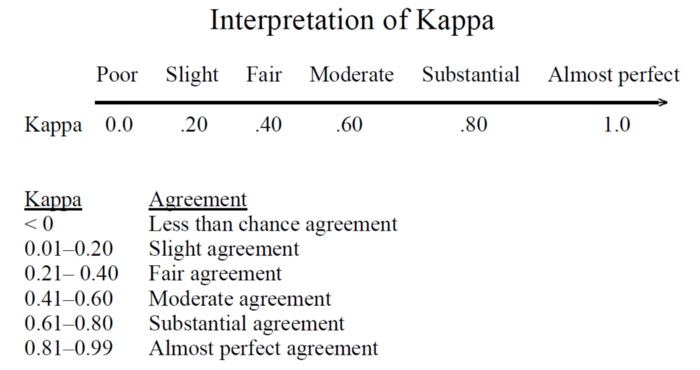

In [180]:
# Kappa interpretation on model agreement
cohen_kappa_score(Y_test, forest.predict(X_test))
# cohen_kappa_score(Y_test,rf_Grid.score(X_test))

0.3904372283303503